<h1>Analysis 3 - ARIMA modelling</h1>

Based on Yujing Yang py file - ARIMA_YangY_20210820

In [31]:
import pandas as pd
import numpy as np
import re
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller as ADF
from statsmodels.stats.diagnostic import acorr_ljungbox
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import pmdarima as pm
import datetime
from matplotlib import pyplot as plt
from scipy import stats
from glob import glob
import requests
import json
import seaborn as sns
import re
from datetime import datetime
from datetime import date



data_path = "D:\MSDS\DS Project\Data\CL51"

Note - for Merriwa the CL51 data there is completely missing data at 17/2/2021 at 10am.

Previously this was not dealt with explicitly. With time series prediction using ARIMA, this needs to be filled in.

Have used forward fill method

In [138]:
'''
Read and process the CL51 data
'''
def read_csv(file1):
    with open(file1, 'r') as f:
        reader = pd.read_csv(f)
    ceilometer = reader[['# Time', 'bl_height']]
    return ceilometer

def read_all(cl51):
    #TK - Adjusted for local file path
    df = pd.DataFrame(columns = ['# Time', 'bl_height'])
    for i in range(len(cl51)):
        file1 = data_path + '\\' + cl51[i] + '.csv'
        ceilometer = read_csv(file1)
        df = pd.concat([df, ceilometer], ignore_index=True)
    return df

cl51_Lidcombe = ['L3_DEFAULT_0_20210212_Lidcombe','L3_DEFAULT_0_20210213_Lidcombe',
               'L3_DEFAULT_0_20210214_Lidcombe', 'L3_DEFAULT_0_20210215_Lidcombe',
               'L3_DEFAULT_0_20210216_Lidcombe','L3_DEFAULT_0_20210217_Lidcombe', 
               'L3_DEFAULT_0_20210218_Lidcombe']

cl51_Merriwa = [re.sub('Lidcombe', 'Merriwa', name) for name in cl51_Lidcombe]


#Make this more generic
def data_process(data_list):
    df = read_all(data_list)
    df_result = df.replace(-999, np.nan)
    df_result['datetime'] = pd.to_datetime(df_result['# Time'], format='%d/%m/%Y %H:%M:%S')
    df_result = df_result.set_index('datetime')
    df_result = df_result.assign(revised_bl_height=df_result.bl_height.interpolate(method='time'))
    
    #wrap the resampling in here
    df_result = pd.DataFrame(df_result['revised_bl_height'].resample('1H').mean().round(3)).ffill()
    df_result['# Time'] = df_result.index

    df_result = df_result.groupby([
        df_result['# Time'].dt.strftime('%Y-%m-%d').rename('Date'), 
        df_result['# Time'].dt.hour.rename('Hour')
    ])['revised_bl_height'].mean().reset_index(name='CL_BLH').set_index(['Date', 'Hour'])

    
    return df_result

In [140]:
# data_process(cl51_Merriwa)

In [27]:
def parse_CTM(site, time_offset=10):
    # Careful! The seperator is not ',' but ', ' (space)
    df = pd.concat([pd.read_csv(file, sep=r'\s*,\s*', engine='python') for file in glob(f'CTM_ModelOutput/*{site}.csv')])

    # parse date string
    from datetime import timedelta
    df['Time'] = pd.to_datetime(df[['date', 'time']].astype(str).apply('-'.join, 1), format='%Y%m%d-%H') + timedelta(hours=time_offset)

    df = df.groupby([
        df['Time'].dt.strftime('%Y-%m-%d').rename('Date'), 
        df['Time'].dt.hour.rename('Hour')
    ])['mixing_height'].mean().reset_index(name='CTM_BLH').set_index(['Date', 'Hour'])

    return df

In [28]:
'''
2. Import WRF data
'''

data_path = "D:\MSDS\DS Project\Data"

wrf_data_path = "\\WRF"

wrf_data_fn_merriwa = ['PBLH_series329_20210212', 'PBLH_series329_20210213',
                       'PBLH_series329_20210214','PBLH_series329_20210215',
                       'PBLH_series329_20210216','PBLH_series329_20210217',
                      'PBLH_series329_20210218']

#Use RE
wrf_data_fn_lidcombe = [re.sub('series329', 'series2141',data) for data in wrf_data_fn_merriwa]

wrf_full_file_path_merriwa = [data_path+wrf_data_path+'\\'+path+'.txt' for path in wrf_data_fn_merriwa]
wrf_full_file_path_lidcombe = [data_path+wrf_data_path+'\\'+path+'.txt' for path in wrf_data_fn_lidcombe]

#Initialise a Dataframe with first table
wrf_df_merriwa = pd.read_csv(wrf_full_file_path_merriwa[0], header = None, delimiter = r'\s+')
wrf_df_lidcombe = pd.read_csv(wrf_full_file_path_lidcombe[0], header = None, delimiter = r'\s+')

#Loop through the rest of the data and append. Note both data is same length
for i in range(1,len(wrf_full_file_path_merriwa)):
    wrf_df_merriwa = wrf_df_merriwa.append(pd.read_csv(wrf_full_file_path_merriwa[i], header = None, delimiter = r'\s+') , ignore_index = True)
    wrf_df_lidcombe = wrf_df_lidcombe.append(pd.read_csv(wrf_full_file_path_lidcombe[i], header=None, delimiter = r'\s+'),  ignore_index = True)
    
wrf_df_merriwa = wrf_df_merriwa.rename(columns = {0:'datetime', 1:'WRF PBLH'})
wrf_df_lidcombe = wrf_df_lidcombe.rename(columns = {0:'datetime', 1:'WRF PBLH'})


wrf_df_merriwa['date'] = wrf_df_merriwa.datetime.str[:10]
wrf_df_merriwa['time'] = wrf_df_merriwa.datetime.str[11:13].astype(int)

wrf_df_lidcombe['date'] = wrf_df_lidcombe.datetime.str[:10] 
wrf_df_lidcombe['time'] = wrf_df_lidcombe.datetime.str[11:13].astype(int)


In [29]:
def convert_df_to_datetime_wrf(df):
    df['time_AEST'] = (df['time'] + 10) % 24

    #Loop through and convert date to proper date
    length_data = len(df)

    #Defined new columns
    df['date_proper'] = 0
    df['datetime'] = ''

    #Sets the date based on change of time and creates a datetime stamp
    #Very clunky but it works
    for i in range(length_data):
        date_1 = str(df.loc[i,'date'])

        year_date_1 = date_1[:4]
        month_date_1 = date_1[5:7]
        day_date_1 = int(date_1[8::])

        if i > 1:
            #This means the day has changed
            if (df.loc[i,'time_AEST'] < df.loc[i-1,'time_AEST']):
                day_date_1 += 1

        df.loc[i, 'date_proper'] = date(int(year_date_1), int(month_date_1), day_date_1)

        #Days are monotonic
        if i > 1:
            if (df.loc[i,'date_proper'] < df.loc[i-1,'date_proper']):
                df.loc[i,'date_proper'] = df.loc[i-1,'date_proper']

        date_proper_1 = str(df.loc[i,'date_proper'])
        time_1 = str(df.loc[i, 'time_AEST'])

        datetime_str = date_proper_1 + " " + time_1
        df.loc[i, 'datetime'] = datetime.strptime(datetime_str, '%Y-%m-%d %H')

    df = df[~df.index.duplicated(keep = 'first')]
    
    df['datetime'] = pd.to_datetime(df['datetime'], format = '%Y-%m-%d %H')
    #Set index to datetime
    df = df.groupby([
        df['datetime'].dt.strftime('%Y-%m-%d').rename('Date'), 
        df['datetime'].dt.hour.rename('Hour')
    ])['WRF PBLH'].mean().reset_index(name='WRF_BLH').set_index(['Date', 'Hour'])

    
    return df

In [32]:
wrf_df_merriwa = convert_df_to_datetime_wrf(wrf_df_merriwa)
wrf_df_lidcombe = convert_df_to_datetime_wrf(wrf_df_lidcombe)

In [144]:
def join_CL_CTM_WRF(site, wrf_df, df_list):
    CLdf = data_process(df_list)
    CTMdf = parse_CTM(site)
    WRFdf = wrf_df.copy(deep = True)
    
    df_joined = CLdf.join(CTMdf, how='inner')
    
    df_joined = df_joined.join(WRFdf, how = 'inner').reset_index()
    
    df_joined['datetime'] = pd.to_datetime(df_joined['Date'] +' '+ df_joined['Hour'].astype(str)+':00', format = '%Y-%m-%d %H:%M')

    df_joined = df_joined.set_index('datetime')
    
    df_joined = df_joined.drop(columns = ['Date','Hour'])
#     df_joined['datetime'] = pd.to_datetime(df_joined[['Date', 'Hour']].astype(str).apply(' '.join, 1), format='%Y%m%d %H')
    return df_joined


In [152]:
df_merriwa = join_CL_CTM_WRF('Merriwa', wrf_df_merriwa, cl51_Merriwa)
df_lidcombe = join_CL_CTM_WRF('Lidcombe', wrf_df_lidcombe, cl51_Lidcombe)

In [154]:
# df_lidcombe

TK - Breaking down the analysis i.e. the ARIMA function

In [5]:
# #Derive the data - this is just the raw data, unaveraged over time i.e. straight from the datasource
# cl51_Lidcombe= data_process(cl51_Lidcombe)
# cl51_Merriwa = data_process(cl51_Merriwa)

In [9]:
#sanity check
# cl51_Merriwa.to_csv('merriwa_v3.csv')

In [45]:
def time_series_checks(df, location):
    #Stationarity check - do this on whole data..
    adf = ADF(df)
    adf_p_val = adf[1]

    #P-value is 5.4e-0.5. Basically this is stationary.

    #Ljung - Box test:
    #H0: series is independently distributed i.e. random
    #H1: is not
    ljungbox = acorr_ljungbox(df)
    ljungbox_p_val = ljungbox[1]
    
    random_series = False
    for i,val in enumerate(ljungbox_p_val):
        if val > 0.05:
            random_series = True
            break
    
    print('Time series checks at %s\nADF test p-value:%.5f\nLjung-Box test - series is random:%s' %(location, adf_p_val, random_series))

In [147]:
time_series_checks(df_merriwa['CL_BLH'], 'Merriwa')

Time series checks at Merriwa
ADF test p-value:0.00210
Ljung-Box test - series is random:False


C:\Users\Thomas\Anaconda3\lib\site-packages\statsmodels\stats\diagnostic.py:533: FutureWarning: The default value of lags is changing.  After 0.12, this value will become min(10, nobs//5). Directly setlags to silence this warning.
  "lags to silence this warning.", FutureWarning)
C:\Users\Thomas\Anaconda3\lib\site-packages\statsmodels\stats\diagnostic.py:559: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


In [155]:
time_series_checks(df_lidcombe['CL_BLH'], 'Lidcombe')

Time series checks at Lidcombe
ADF test p-value:0.00006
Ljung-Box test - series is random:False


C:\Users\Thomas\Anaconda3\lib\site-packages\statsmodels\stats\diagnostic.py:533: FutureWarning: The default value of lags is changing.  After 0.12, this value will become min(10, nobs//5). Directly setlags to silence this warning.
  "lags to silence this warning.", FutureWarning)
C:\Users\Thomas\Anaconda3\lib\site-packages\statsmodels\stats\diagnostic.py:559: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


In [156]:
train_end = '2021-02-18 09:00:00'

df_merriwa_train = df_merriwa[:train_end]
df_lidcombe_train = df_lidcombe[:train_end]

In [149]:
'''
ARIMA modelling function
'''

def ARIMA_modelling(df):
    #Define train periods
    train_end = '2021-02-18 09:00:00'
    test_start = '2021-02-18 10:00:00'
    test_end = '2021-02-19 09:00:00'
    
    train = df[:train_end]
    test = df[test_start:test_end]
    
    #Fitting the ARIMA model
    
    #If there is seasonality what number of d in ARIMA (pdq) is required to make the time series stationary
#Results show that there is no seasonality in the data.
    D = pm.arima.nsdiffs(train['CL_BLH'], 24)

    #Lets try vanilla auto_arima
    #So it seems ARIMA (1,0,0) works for this time series - which is what we got anyway
    stepwise_model = pm.auto_arima(train['CL_BLH'], trace = True)

    order_param=stepwise_model.order
    seasonal_order_param = stepwise_model.seasonal_order
       
    #We want to use the previous hour to predict next hour
    # forecast = pd.DataFrame(predict_sunspots)

    #Use rolling forecast - https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/

    history_df = train.copy(deep = True)

    predictions = []

    # walk-forward validation
    for t in range(len(test)):
        model = sm.tsa.statespace.SARIMAX(history_df['CL_BLH'], order=order_param, seasonal_order=seasonal_order_param,
                                          enforce_stationarity=False, enforce_invertibility=False)

        model_fit = model.fit()

        #This is one time step forecast
        output = model_fit.forecast()

        #Predicted value append
        yhat = output[0]
        predictions.append(yhat)

        #Basically append new observations as they become available.
        #Technically, this trains new model for every new history point.
        #So we are doing a 1 hour prediction - 24/25 times
        obs = test.iloc[t]
        history_df = history_df.append(obs)
        
    #Write out results
    results_df = test.copy(deep=True)
    results_df['Predicted'] = predictions
    
    return results_df

In [157]:
df_merriwa_arima = ARIMA_modelling(df_merriwa)
df_lidcombe_arima = ARIMA_modelling(df_lidcombe)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.62 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1981.363, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1981.966, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1982.188, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1979.494, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1983.651, Time=0.05 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.778 seconds


C:\Users\Thomas\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
C:\Users\Thomas\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
C:\Users\Thomas\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
C:\Users\Thomas\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
C:\Users\Thomas\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
C:\Users\T

C:\Users\Thomas\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=2039.826, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=2160.759, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=2034.834, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=2078.107, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2406.559, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=2036.012, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=2036.036, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=2038.017, Time=0.15 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=2049.319, Time=0.03 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.605 seconds


C:\Users\Thomas\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
C:\Users\Thomas\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
C:\Users\Thomas\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
C:\Users\Thomas\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
C:\Users\Thomas\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
C:\Users\T

In [161]:
'''
Plots - define a function
'''
def combined_predicted_plots(df, title):
    ax = df.plot(figsize = (14,6), title = title)
    #Change settings for CL_BLH
    ax.lines[0].set_linestyle('dashed')
    ax.lines[0].set_linewidth(3)
    #Change settings for CTM BLH
    ax.lines[1].set_linestyle('dashed')
    ax.lines[2].set_linestyle('dashed')
    #Reset legend
    ax.legend()
    plt.xlabel('Date time')
    plt.ylabel('Boundary layer height (m)')

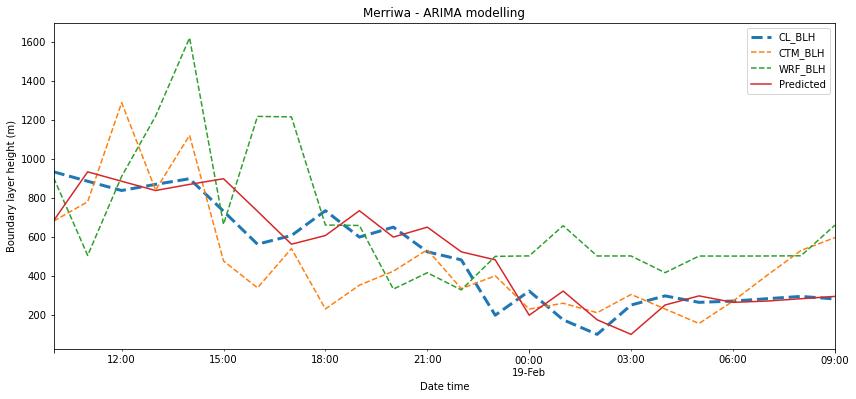

In [165]:
combined_predicted_plots(df_merriwa_arima, 'Merriwa - ARIMA modelling')

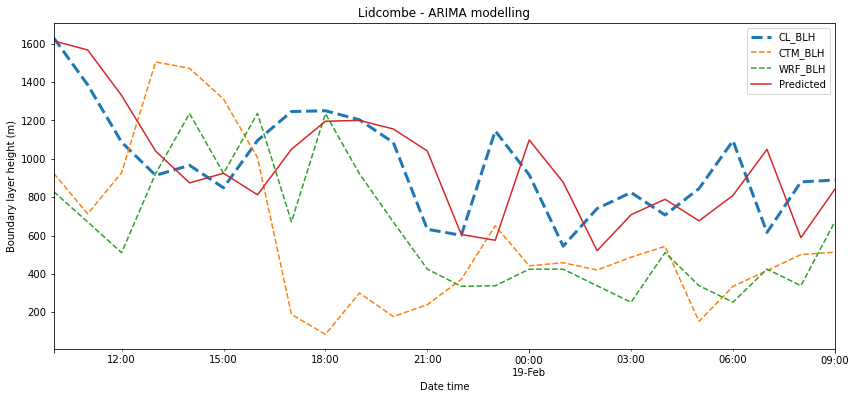

In [164]:
combined_predicted_plots(df_lidcombe_arima, 'Lidcombe - ARIMA modelling')

<h4> Test metrics </h4>

In [166]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean


In [167]:
'''
Sourced from: https://github.com/rkawsar/ambhas/blob/master/ambhas/errlib.py

This basically looks like a modified version of R2?
'''

def index_agreement(s, o):
    """
    index of agreement

    Willmott (1981, 1982) 
    input:
        s: simulated
        o: observed
    output:
        ia: index of agreement
    """
    ia = 1 -(np.sum((o-s)**2))/(np.sum((np.abs(s-np.mean(o))+np.abs(o-np.mean(o)))**2))
    return ia

'''
Calculate mean bias error
'''
def mean_bias_error(y_true, y_pred):
    return np.mean(y_pred - y_true)


def DTW_dist(y_true, y_pred):
    distance, path = fastdtw(y_true, y_pred, dist=euclidean)
    
    return distance, path

'''
Sourced from: https://github.com/CamDavidsonPilon/Python-Numerics/blob/master/TimeSeries/MASE.py

'''
def MASE(training_series, testing_series, prediction_series):
    """
    Computes the MEAN-ABSOLUTE SCALED ERROR forcast error for univariate time series prediction.
    
    See "Another look at measures of forecast accuracy", Rob J Hyndman
    
    parameters:
        training_series: the series used to train the model, 1d numpy array
        testing_series: the test series to predict, 1d numpy array or float
        prediction_series: the prediction of testing_series, 1d numpy array (same size as testing_series) or float
        absolute: "squares" to use sum of squares and root the result, "absolute" to use absolute values.
    
    """

    n = training_series.shape[0]
    d = np.abs(  np.diff( training_series) ).sum()/(n-1)
    
    errors = np.abs(testing_series - prediction_series )
    return errors.mean()/d

In [168]:
'''
Function: Calculates and prints out the varoius metrics
'''

def satistical_comps_on_df(y_true, y_pred, train, location):    
    y_true = y_true.to_numpy()
    y_pred = y_pred.to_numpy()
    train = train.to_numpy()
    
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mbe = mean_bias_error(y_true, y_pred)
    ioa = index_agreement(y_pred, y_true)
    dtw_dist, path = DTW_dist(y_true, y_pred)
    mase = MASE(train, y_true, y_pred)
    
    print('At %s\nIndex of agreement:%.5f\nRoot mean squared error:%.5f\nMean absoluate error:%.5f\nMean bias error:%.5f\nDTW distance:%.2f\nMean absolute scaled error:%.5f' % (location, ioa, rmse, mae, mbe, dtw_dist, mase))

In [171]:
satistical_comps_on_df(df_merriwa_arima['CL_BLH'], df_merriwa_arima['Predicted'], df_merriwa_train['CL_BLH'], 'Merriwa ARIMA')

At Merriwa ARIMA
Index of agreement:0.94645
Root mean squared error:117.34194
Mean absoluate error:90.30179
Mean bias error:16.70854
DTW distance:262.42
Mean absolute scaled error:0.48112


In [172]:
satistical_comps_on_df(df_lidcombe_arima['CL_BLH'], df_lidcombe_arima['Predicted'], df_lidcombe_train['CL_BLH'], 'Lidcombe ARIMA')

At Lidcombe ARIMA
Index of agreement:0.79888
Root mean squared error:236.02521
Mean absoluate error:186.73444
Mean bias error:-8.40773
DTW distance:990.07
Mean absolute scaled error:0.85293


<h1> OLD CODE</h1>

In [6]:
def ARIMA_model(data):
    data_minute = data['revised_bl_height'].resample('1H').mean().round(3)
    #split train and test
    train = data_minute['2021-02-14':'2021-02-18']
    train = pd.DataFrame(train)
    train.plot(figsize=(12,8))
    plt.title("cl51 Lidcombe train")
    plt.savefig('./bl_height.jpg')
    plt.show()


    # stationary test
    adf = ADF(train)
    #p:0.0001 the series is stable

    #white noise test
    lb = acorr_ljungbox(train, lags=1)
    #lb: 4.109e-22 the series is not random

    #acf pacf
    fig = plt.figure(figsize=(12, 8))
    ax1 = fig.add_subplot(211)
    fig = sm.graphics.tsa.plot_acf(train, lags=30, ax=ax1)
    ax2 = fig.add_subplot(212)
    fig = sm.graphics.tsa.plot_pacf(train, lags=30, ax=ax2)


    #auto parameters use AIC to select (p,d,q) (P,D,Q,S), S is the seasonal param, set myself
    #the problem is the choice of S. in auto_arima model, it is denoted as m=24.
    D = pm.arima.nsdiffs(train, 24)
    stepwise_model = pm.auto_arima(train, start_P=1, start_q=0, max_p=2, max_q=4,
                                   max_d=2, m=24, seasonal=True, d=0, D=D, trace=True,
                                   error_action='ignore', suppress_warnings=True, stepwise=True)
    order_param=stepwise_model.order
    seasonal_order_param = stepwise_model.seasonal_order

    #prediction
    model = sm.tsa.statespace.SARIMAX(train, order=order_param, seasonal_order=seasonal_order_param,
                                      enforce_stationarity=False, enforce_invertibility=False)
    results = model.fit()
    predict_sunspots = results.forecast(11)
    forcast = pd.DataFrame(predict_sunspots)

    plt.figure(figsize=(6, 6))
    plt.plot(forcast)
    plt.plot(data_minute['2021-02-19':])
    plt.title("prediction2")
    plt.savefig('./prediction2.jpg')
    plt.show()